$$
\def\CC{\bf C}
\def\QQ{\bf Q}
\def\RR{\bf R}
\def\ZZ{\bf Z}
\def\NN{\bf N}
$$
# Lean Tutorial

This tutorial runs through all of the steps for doing a project with
Marvin from start-to-finish with no extra fat. We recommend the use of
`ipython` or `jupyter notebook` when using Marvin. You can start either
from a terminal with `ipython` or `jupyter notebook`.

## Project Description

**Calculate the \[NII\]/H**$\alpha$ **ratio for star-forming spaxels in
galaxies with stellar mass between** $10^{10}$ **and** $10^{11}$ **.**

## Sample Selection

Marvin uses a simplified query syntax (in both
[Web](https://dr15.sdss.org/marvin/search/) and local queries) that
understands the MaNGA database schema, so you don't have to write
complicated SQL queries.

**Goal**: Find galaxies with stellar mass between $10^{10}$ and
$10^{11}$.

Create the query with `~marvin.tools.query.query.doQuery` and run it
(limit to only 3 results for demo purposes):

In [2]:
from marvin.tools.query import doQuery
q, r = doQuery(search_filter='nsa.sersic_logmass >= 10 and nsa.sersic_logmass <= 11', limit=3)

**Tip**: see [Marvin Query](marvin-query.ipynb) to learn the basics of
querying. See [Example Queries](marvin-query-examples.ipynb) and [Marvin
Query Syntax Tutorial](marvin-sqlboolean.ipynb) for help with designing
search filters.

View the `~marvin.tools.query.results.Results`. You may see a different
set of results. That is ok as long as you see some set of results.:

In [3]:
df = r.toDF()
df

,mangaid,plateifu,sersic_logmass
0,1-109056,8077-6103,10.200445
1,1-109081,8077-12705,10.862523
2,1-109112,8078-1901,10.128307


Convert into `../tools/maps` objects:

In [4]:
r.convertToTool('maps')
r.objects
galaxies = r.objects

Converting results to Marvin Maps objects


## Get the Maps

Alternatively, maybe we already knew our galaxy IDs, which we can use to
create `~marvin.tools.maps.Maps` objects:

In [5]:
from marvin.tools.maps import Maps
mangaids = ['1-245458', '1-22301', '1-605884']
galaxies = [Maps(mangaid=mangaid) for mangaid in mangaids]

[WARNING]: Specified hdu=MANGA not found, reading in first available table (hdu=1) instead. This will result in an error in future versions! (AstropyDeprecationWarning)


Get the H$\alpha$ maps:

In [6]:
haflux_maps = [galaxy['emline_gflux_ha_6564'] for galaxy in galaxies]

Plot H$\alpha$ map of the second galaxy:

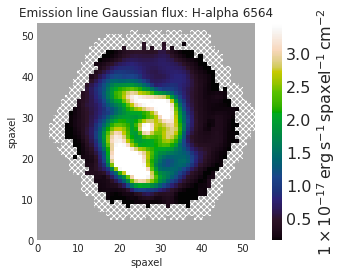

In [7]:
haflux_map = haflux_maps[1]
fig, ax = haflux_map.plot()

## Get Spectrum and Model Fit

Let's take a look at the model fits a spaxel. The easiest way is to
navigate to the [Galaxy page for
7992-6101](https://dr15.sdss.org/marvin/galaxy/7992-6101) and click on
the red "Map/SpecView Off" button.

However, we can also plot the spectrum and model fits in Python. First,
we can find the coordinates of a spaxel by moving our cursor around the
interactive matplotlib plotting window. When the cursor is over the
spaxel of interest, the coordinates will appear in the lower right.

Then we can create a `~marvin.tools.spaxel.Spaxel` object by accessing
the parent `~marvin.tools.maps.Maps` object from the
`~marvin.tools.quantities.Map` object (`haflux_map.maps`) and retrieve
the model fit.

In [8]:
spax = galaxies[1].getSpaxel(x=28, y=24, xyorig='lower', cube=True, modelcube=True)

[WARNING]: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here. (DeprecationWarning)
[WARNING]: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information. (DeprecationWarning)


Now let's plot the spectrum and model fit:

In [9]:
import matplotlib.pyplot as plt
# Set matplotlib style sheet. Undo with matplotib.rcdefaults().
plt.style.use('seaborn-darkgrid')

[WARNING]: The truth value of a Quantity is ambiguous. In the future this will raise a ValueError. (AstropyDeprecationWarning)


(7100.0, 7500.0, 0.3, 0.65)

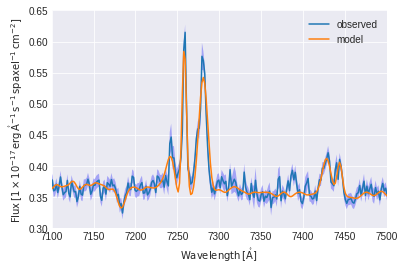

In [10]:
ax = spax.flux.plot()
ax.plot(spax.full_fit.wavelength, spax.full_fit.value)
ax.legend(list(ax.get_lines()), ['observed', 'model'])
ax.axis([7100, 7500, 0.3, 0.65])

## Plot BPT Diagram

The `~marvin.tools.maps.Maps.get_bpt` returns masks for spaxels of
different ionization types and the Figure object.

[WARNING]:  (MatplotlibDeprecationWarning)


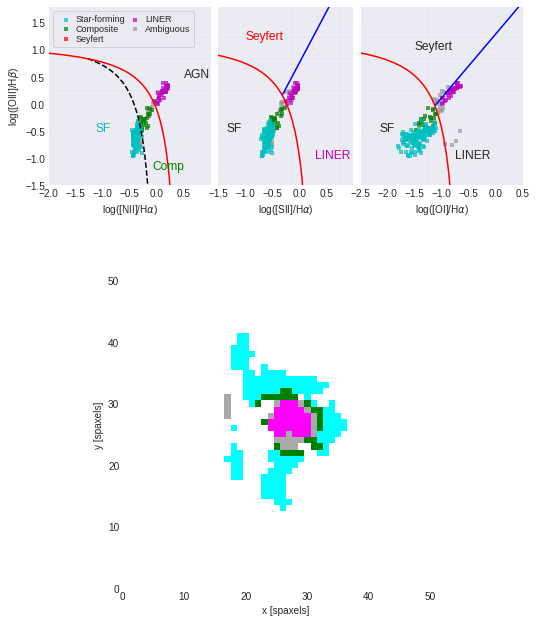

In [11]:
masks, fig, axes = galaxies[1].get_bpt()

For a detailed description see [BPT Diagrams](https://sdss-marvin.readthedocs.io/en/latest/tools/bpt.html).

## Select Star-forming Spaxels

Select the star-forming spaxels that are in the star-forming region of
each diagnostic diagram (hence the "global" keyword):

In [ ]:
sf = masks['sf']['global']

Return the complement of the BPT global star-forming mask (`True` means
star-forming) using `~` and mark those spaxels as DONOTUSE since they
are non-star-forming spaxels.

In [ ]:
mask_non_sf = ~sf * haflux_map.pixmask.labels_to_value('DONOTUSE')

Do a bitwise OR between the DAP mask and the non-star-forming mask:

In [ ]:
mask = haflux_map.mask | mask_non_sf

Plot with our new mask:

In [ ]:
haflux_map.plot(mask=mask)

## Plot \[NII\]/H$\alpha$ Flux Ratio for Star-forming Spaxels

Calculate \[NII\]6585/H$\alpha$ flux ratio:

In [ ]:
maps_7992_6101 = galaxies[1]
nii = maps_7992_6101['emline_gflux_nii_6585']
ha = maps_7992_6101['emline_gflux_ha_6564']
nii_ha = nii / ha

Plot the \[NII\]/H$\alpha$ flux ratio for the star-forming spaxels:

In [ ]:
nii_ha.plot(mask=mask, cblabel='[NII]6585 / Halpha flux ratio')

## Next Steps

-   [Getting Started](https://sdss-marvin.readthedocs.io/en/stable/getting-started.html) (more general introduction to Marvin)
-   [Plotting Tutorial](https://sdss-marvin.readthedocs.io/en/stable/tutorials/plotting-tutorial.html)
-   [Download Data](https://sdss-marvin.readthedocs.io/en/stable/tools/downloads.html) (avoid repeating the same remote API calls every time you run your script)